In [92]:
%pylab inline
import healpy
from ducc0 import sht
from scipy.interpolate import InterpolatedUnivariateSpline
from astropy import units as u

Populating the interactive namespace from numpy and matplotlib


### Load data
- 2degree apodized mask
- Planck15
- 80% sky

- Data is a single SMICA separated CMB monte carlo map

In [14]:
root = '/projects/QUIJOTE/Oliver/planck/'
maskfile = 'HFI_Mask_GalPlane-apo2_2048_R2.00.fits'
datafile = "dx12_v3_smica_cmb_mc_00000_raw.fits"
Nside = 512

In [79]:
beam = healpy.ud_grade(healpy.read_map(root+'beams_030_6289408.fits'),Nside)
beam_lm = to_lm(beam)
beam_Cl = to_cl(beam_lm)

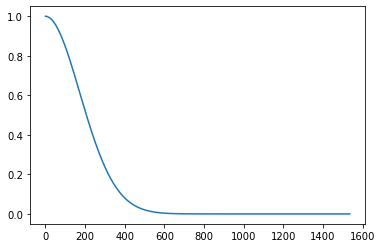

In [81]:
plt.plot(l,beam_Cl/beam_Cl[0])

In [3]:
mask_hires = healpy.read_map(root+maskfile,field=4) # 80%
raw_data_hires = healpy.read_map(root+datafile,field=0) # temperature

data_hires = mask_hires*raw_data_hires

# Downgrade maps
mask = healpy.ud_grade(mask_hires,Nside)
raw_data = healpy.ud_grade(raw_data_hires,Nside)
data = healpy.ud_grade(data_hires,Nside)

### Plot maps

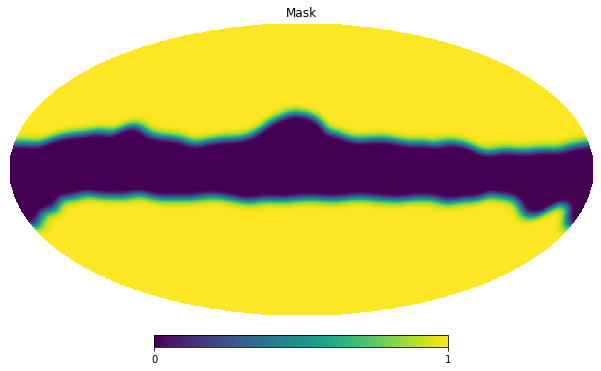

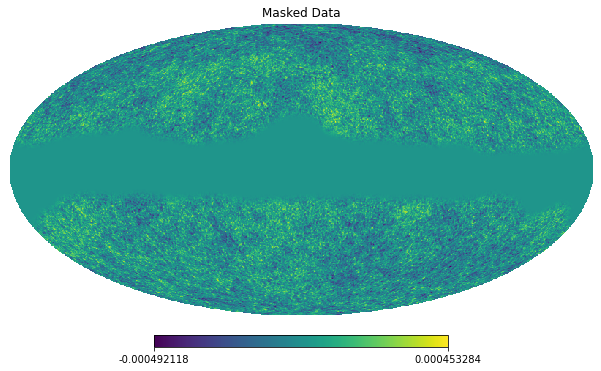

In [4]:
healpy.mollview(mask,title='Mask')
healpy.mollview(data,title='Masked Data')

### Compute spectra

- NB: normalizing by $\langle{W^2\rangle}$

In [87]:
def to_lm(input_map):
    return healpy.map2alm(input_map,use_weights=True)
def to_map(input_lm):
    return healpy.alm2map(input_lm,Nside)
def to_cl(input_lm):
    return healpy.alm2cl(input_lm)

# masked
data_lm = to_lm(data)
av_mask_sq = np.mean(mask**2.)
data_Cl = to_cl(data_lm)/av_mask_sq

# raw
raw_data_lm = to_lm(raw_data)
raw_data_Cl = to_cl(raw_data_lm)

# l array
l = np.arange(len(data_Cl))
lmax = max(l)

# All ell, m pairs
l_arr,m_arr=healpy.Alm().getlm(lmax)
assert len(l_arr)==len(data_lm)

### Create theory $C_\ell$

In [88]:
from classy import Class
cosmo = Class()

cosmo.set({'output':'tCl,lCl,mPk','l_max_scalars':lmax+1,'lensing':'yes',
           'omega_b':0.022383,
           'non linear':'no',
           'omega_cdm':0.12011,
           'h':0.6732,
           'm_ncdm':0.06,
           'N_ncdm':1,
           'tau_reio':0.0543,
           'A_s':1e-10*np.exp(3.0448),
           'n_s':0.96605});
cosmo.compute()

### how do we treat beam???
### is beam the problem???

In [89]:
beam_l=healpy.gauss_beam((10.*u.arcmin).to_value(u.radian), lmax=lmax)

In [90]:
Cl_dict = cosmo.lensed_cl(lmax);
Cl_th = Cl_dict['tt']*cosmo.T_cmb()**2
Cl_th_interp = InterpolatedUnivariateSpline(l,Cl_th)
Cl_th_lm = Cl_th_interp(l_arr) # on full l,m array

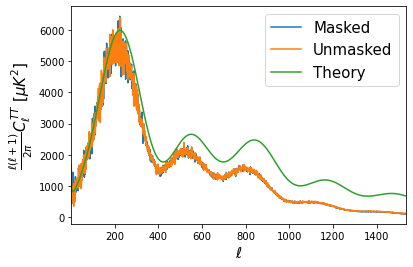

In [91]:
pref = l*(l+1)/(2.*np.pi)*1e12
def plotter(Cl,label):
    plt.plot(l[2:],(pref*Cl)[2:],label=label)
    plt.xlabel(r'$\ell$',fontsize=15)
    plt.ylabel(r'$\frac{\ell(\ell+1)}{2\pi}C_\ell^{TT}\,\,[\mu K^2]$',fontsize=15);
    plt.xlim([2,lmax]);
    plt.legend(fontsize=15)
plotter(data_Cl,'Masked')
plotter(raw_data_Cl,'Unmasked')
plotter(Cl_th,'Theory')

## Inverse Variance Mask

In [110]:
def apply_Sinv(input_map):
    """Apply approximate inverse variance weight to map"""
    input_lm = to_lm(input_map)
    output_lm = input_lm/Cl_th_lm/av_mask_sq
    output_lm[l_arr<2] = 0. # zero troublesome modes
    output_map = to_map(output_lm,Nside)
    return output_map

Sinv_data = apply_Sinv(data)

In [114]:
# Compute power spectrum of S^-1*data for testing
Sinv_data_Cl = healpy.alm2cl(healpy.map2alm(Sinv_data))

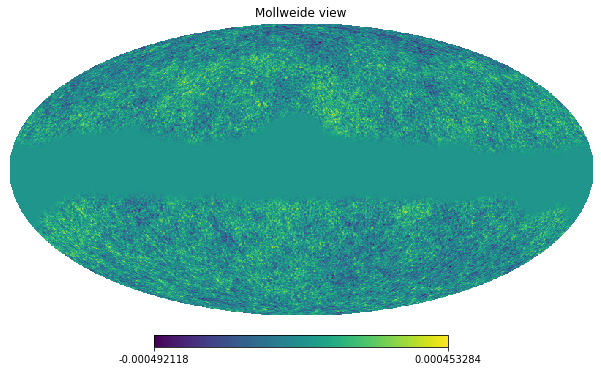

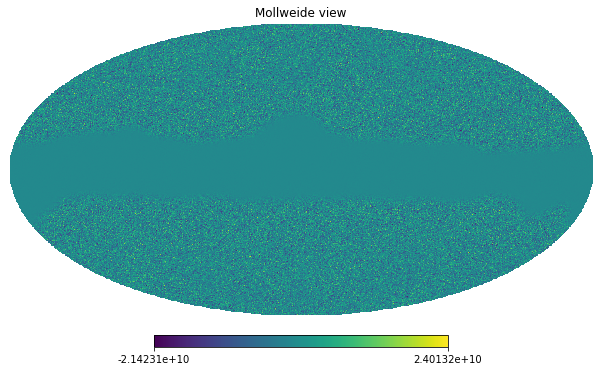

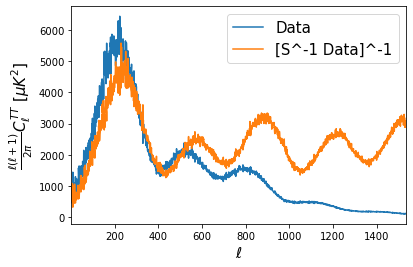

In [115]:
healpy.mollview(data,'Data')
healpy.mollview(Sinv_data,'S^-1 Data')

plt.figure()
plotter(data_Cl,'Data')
plotter(1./Sinv_data_Cl,'[S^-1 Data]^-1')

### Construct Trispectrum Numerator

In [118]:
# Compute W * S^-1 * a
W_Sinv_data = mask*Sinv_data

# Define bin
l_bin = (l_arr>=10)&(l_arr<20)

# Compute +-_H_b
plus_H_b = healpy.map2alm()